# General imports

In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os

# Upload the dataset

In [ ]:
!unzip fer_2013.zip

In [3]:
train_data_dir='fer_2013/train'
validation_data_dir='fer_2013/test'

In [4]:
num_classes = 7
img_shape = (48, 48)
batch_size = 32

In [5]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=30,
                shear_range=0.3,
                zoom_range=0.3,
                width_shift_range=0.4,
                height_shift_range=0.4,
                horizontal_flip=True,
                fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

The train_datagen variable will artificially expand the dataset using the following:
* rotation_range: Degree range for random rotations. Here we decide to use 30 degrees.
* shear_range: Shear Intensity (Shear angle in counter-clockwise direction in degrees). Herewe decide to use 0.3 as shear range.
* zoom_range: Range for random zoom.Herewe decide to use 0.3 as zoom range.
* width_shift_range: This shifts the images by a value across its width.
* height_shift_range : This shifts the images by a value across its height.
* horizontal_flip: This flips the images horizontally.
* fill_mode: This is used to fill in the pixels after making changes to the orientation of the images by the above used methods. Here we decide to use ‘nearest’ as the fill mode as we instruct it to fill the missing pixels in the image with the nearby pixels.

In [6]:
train_generator = train_datagen.flow_from_directory(
                                    train_data_dir,
                                    color_mode='grayscale',
                                    target_size=img_shape,
                                    batch_size=batch_size,
                                    class_mode='categorical',
                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
                                validation_data_dir,
                                color_mode='grayscale',
                                target_size=img_shape,
                                batch_size=batch_size,
                                class_mode='categorical',
                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [80]:
emo_dct = train_generator.class_indices
reversed_emo_dct = {v: k for k, v in emo_dct.items()}

Here we just resclaing the validation data and not performing any other augmentaions as we want to check the model with raw data that is different from the data used in the training of the model.

The dataset contains totally 7 classes namely Angry, Disgust, Fear, Happy, Sad, Surprise and Neutral. The training set consists of a total of 28,709 examples and the test (validation) consists of 7,178 examples.

The options given are:
* directory: The directory of the dataset.
* color_mode: Here we convert the images to gray-scale as i am not interested in the color of the images but only the expressions.
* target_size: Convert the images to a uniform size.
* batch_size: To make baches of data to train.
* class_mode: Her we use ‘categorical’ as the class mode as i am categorizing my images into 5 classes.
* shuffle: To shuffle the dataset for better training.

## 1. Classical approach


Let's try to solve the problem, using Histograms of Oriented Gradients (hog).

In [8]:
import cv2
from skimage.feature import hog
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score

In [9]:
emotions = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
train_data_dict = {
    'emotion': [],
    'usage': [],
    'image': [],
}

test_data_dict = {
    'emotion': [],
    'usage': [],
    'image': [],
}
for emo in emotions:
    dir_list = os.listdir(os.path.join(train_data_dir, emo))
    train_data_dict['emotion'].extend([emo] * len(dir_list))
    train_data_dict['usage'].extend(['Train'] * len(dir_list))
    train_data_dict['image'].extend(dir_list)
    
    dir_list = os.listdir(os.path.join(validation_data_dir, emo))
    test_data_dict['emotion'].extend([emo] * len(dir_list))
    test_data_dict['usage'].extend(['Test'] * len(dir_list))
    test_data_dict['image'].extend(dir_list)
    
train_data = pd.DataFrame.from_dict(train_data_dict)
test_data = pd.DataFrame.from_dict(test_data_dict)

In [10]:
def apply_hog(img_series):
    if img_series.usage == 'Train':
        dir_path = train_data_dir
    else:
        dir_path = validation_data_dir

    img = cv2.imread(os.path.join(dir_path, img_series.emotion, img_series.image))
    return np.asarray(hog(img, orientations=8, pixels_per_cell=(6, 6), cells_per_block=(3, 3)))

Example:

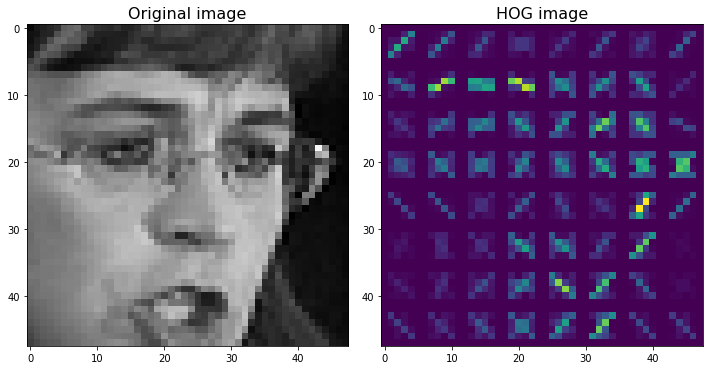

In [11]:
img_series = train_data.iloc[43]
img = cv2.imread(os.path.join(train_data_dir, img_series.emotion, img_series.image))
_, hog_img = hog(img, orientations=8, pixels_per_cell=(6, 6), cells_per_block=(3, 3), visualize=True)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.imshow(img)
ax.set_title('Original image', fontsize=16)
ax.grid(False)

ax = fig.add_subplot(122)
ax.imshow(hog_img)
ax.set_title('HOG image', fontsize=16)
ax.grid(False)

fig.subplots_adjust()
fig.tight_layout()

In [12]:
train_data['hog'] = train_data.apply(apply_hog, axis=1)
test_data['hog'] = test_data.apply(apply_hog, axis=1)

In [13]:
train_data.head()

,emotion,usage,image,hog
0,angry,Train,im3328.png,"[0.19549886344936687, 0.03169163726050675, 0.1..."
1,angry,Train,im1732.png,"[0.026208981743949745, 0.0041619552812732965, ..."
2,angry,Train,im1257.png,"[0.13868694403509282, 0.026325741319812114, 0...."
3,angry,Train,im3613.png,"[0.22998044436155374, 0.1551455254660307, 0.21..."
4,angry,Train,im3070.png,"[0.18273031481581584, 0.1415990387292931, 0.28..."


In [14]:
len(train_data.iloc[0].hog)

2592

Next we need to train the classifier, we will use SVM. But the amount of features is quite high, combining it with the number of train cases, which is also high (28,709). This fact will make the learning process very long, so we will use Principal Component Analysis to reduce the amount of data.

In [50]:
X_train, y_train = np.vstack(train_data.hog.to_numpy()), train_data.emotion
X_test, y_test = np.vstack(test_data.hog.to_numpy()), test_data.emotion

In [16]:
X_train.shape

(28709, 2592)

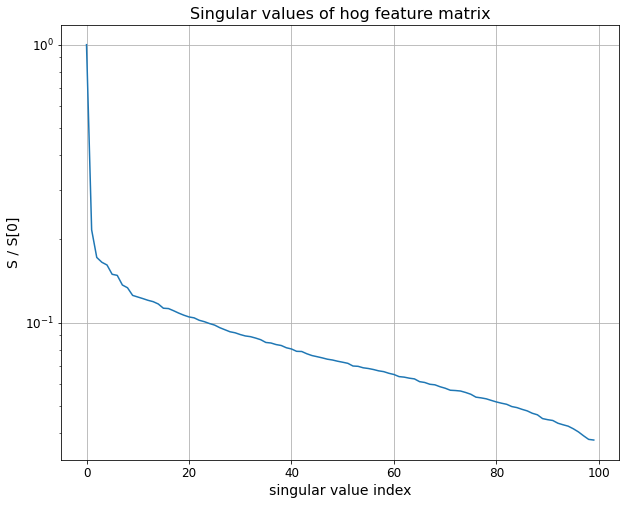

In [46]:
# To reduce the computation time
u, s, vh = np.linalg.svd(X_train[:100])
plt.figure(figsize=(10, 8))
plt.title('Singular values of hog feature matrix', fontsize=16)
plt.ylabel('S / S[0]', fontsize=14)
plt.xlabel('singular value index', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
_ = plt.plot(s/s[0])

We can see, that only the first 2 singular values are significant and we can project hog vectors to 2-dimetional space using PCA.

In [28]:
clf = svm.SVC()
pca = PCA(n_components=2)

In [29]:
small_X = pca.fit_transform(X_train)

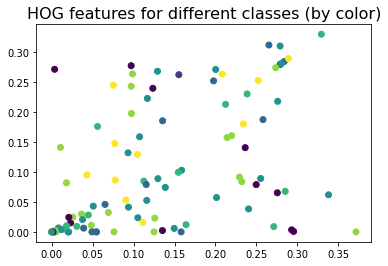

In [45]:
n_to_look = np.random.randint(0, X_train.shape[0], 100)
colors = [emo_dct[emo] for emo in y_train[n_to_look]]
plt.scatter(x=X_train[n_to_look, 0], y=X_train[n_to_look, 1], c=colors)
_ = plt.title('HOG features for different classes (by color)', fontsize=16)

In [30]:
clf.fit(small_X, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [51]:
small_X_test = pca.fit_transform(X_test)

In [53]:
y_pred = clf.predict(small_X_test)

In [54]:
print("Accuracy: " + str(accuracy_score(y_test, y_pred)), end='\n\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.25452772359988857

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.00      0.00      0.00      1024
       happy       0.25      0.88      0.39      1774
     neutral       0.20      0.00      0.01      1233
         sad       0.27      0.20      0.23      1247
   surprised       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.10      0.16      0.09      7178
weighted avg       0.14      0.25      0.14      7178



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As we can see, the results are terrible. We suppose, there are several reasons for that:

* Small resolution of dataset pictures, only 48x48, which makes only 8x8 = 64 hog cells. If we make the cell size smaller, the gradients and their directions will be counted badly.
* Hog wprks well for pattern recognition, so mayy be we need to preprocess the dataset images better.
* Conduct some grid search for SVM and HOG hyperpatrameters.

Still, we suppose, that it is easier to use modern approach - neural networks, specifically convolutional NNs.

## 2. CNN

CNNs are widely used in computer vision and have prooven their strength and reliability.

In [55]:
model = Sequential()

Here we use a Sequential model which defines that all the layers in the network will be one after the other sequentially and storing it in a variable model.

In [56]:
# Block 1
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_shape[0],img_shape[1],1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_shape[0],img_shape[1],1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 4
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 5
model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# Block 6
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# Block 7
model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0

In [57]:
checkpoint = ModelCheckpoint('EmotionDetectionModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [checkpoint, reduce_lr]

In [58]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

nb_train_samples = 28709
nb_validation_samples = 7178
epochs = 50

history = model.fit_generator(
                train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator,
                validation_steps=nb_validation_samples//batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
897/897 [==============================] - ETA: 0s - loss: 2.1319 - accuracy: 0.1962
Epoch 00001: val_loss improved from inf to 1.77937, saving model to EmotionDetectionModel.h5
897/897 [==============================] - 40s 45ms/step - loss: 2.1319 - accuracy: 0.1962 - val_loss: 1.7794 - val_accuracy: 0.2606
Epoch 2/50
897/897 [==============================] - ETA: 0s - loss: 1.8176 - accuracy: 0.2405
Epoch 00002: val_loss improved from 1.77937 to 1.75984, saving model to EmotionDetectionModel.h5
897/897 [==============================] - 39s 44ms/step - loss: 1.8176 - accuracy: 0.2405 - val_loss: 1.7598 - val_accuracy: 0.2640
Epoch 3/50
896/897 [============================>.] - ETA: 0s - loss: 1.7908 - accuracy: 0.2545
Epoch 00003: val_loss improved from 1.75984 to 1.73602, saving model to EmotionDetectionModel.h5
897/897 [==============================] - 39s 43ms/step - loss: 1.7909 - accuracy:

In [59]:
model.save('EmotionDetectionModel')
model.save('EmotionDetectionModel.h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: EmotionDetectionModel/assets


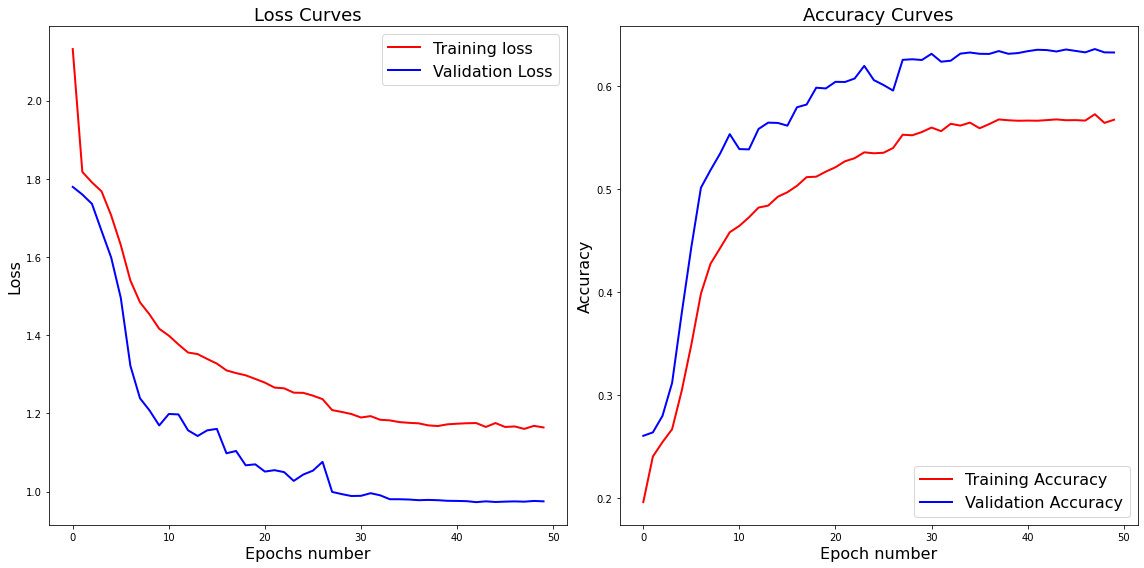

In [78]:
#Plotting accuracy and loss curves for model
fig = plt.figure(figsize=(16, 8))
# Loss Curves
ax = fig.add_subplot(121)
ax.plot(history.history['loss'], 'r', linewidth=2.0)
ax.plot(history.history['val_loss'], 'b', linewidth=2.0)
ax.legend(['Training loss', 'Validation Loss'], fontsize=16)
ax.set_xlabel('Epochs number', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.set_title('Loss Curves', fontsize=18)

# Accuracy Curves
ax = fig.add_subplot(122)
ax.plot(history.history['accuracy'], 'r', linewidth=2.0)
ax.plot(history.history['val_accuracy'], 'b', linewidth=2.0)
ax.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=16)
ax.set_xlabel('Epoch number', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_title('Accuracy Curves', fontsize=18)

fig.subplots_adjust()
fig.tight_layout()

No overfitting, everything is well.

In [73]:

# for res in validation_generator:
#     batch_labels = np.argmax(res[1], axis=1)
#     labels.extend(batch_labels)
#     if len(batch_labels) < batch_size:
#         break

In [84]:
labels = test_data.emotion
y_pred = np.argmax(model.predict(validation_generator), axis=1)
predicted_emotions = [reversed_emo_dct[emo] for emo in y_pred]
print(classification_report(labels, predicted_emotions))

              precision    recall  f1-score   support

       angry       0.52      0.61      0.56       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.51      0.26      0.35      1024
       happy       0.88      0.86      0.87      1774
     neutral       0.09      0.13      0.11      1233
         sad       0.14      0.14      0.14      1247
   surprised       0.01      0.01      0.01       831

    accuracy                           0.38      7178
   macro avg       0.31      0.29      0.29      7178
weighted avg       0.40      0.38      0.38      7178



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


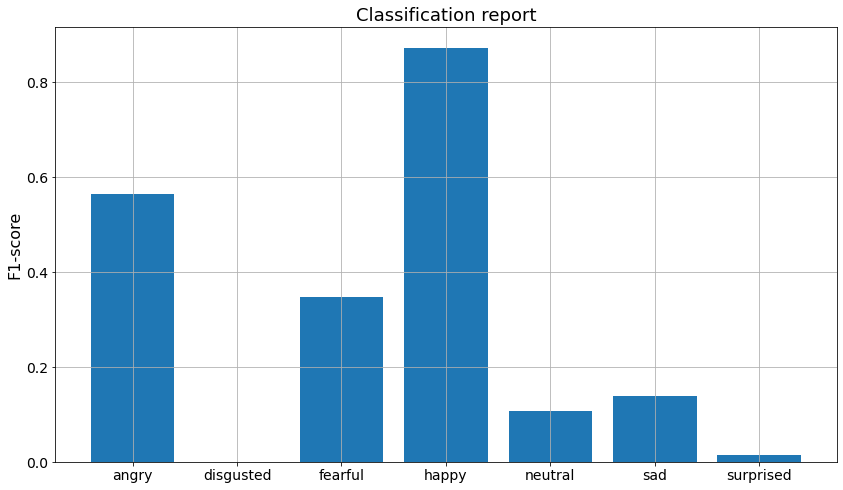

In [114]:
result = classification_report(labels, predicted_emotions, output_dict=True)
for_plot = {k: result[k]['f1-score'] for k in emo_dct.keys()}

plt.figure(figsize=(14, 8))
plt.bar(x=for_plot.keys(), height=for_plot.values())
plt.ylabel('F1-score', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Classification report', fontsize=18)
plt.grid(True)

fig.subplots_adjust()
fig.tight_layout()

This looks pretty similar to the classes distribution in the dataset, what was expected.

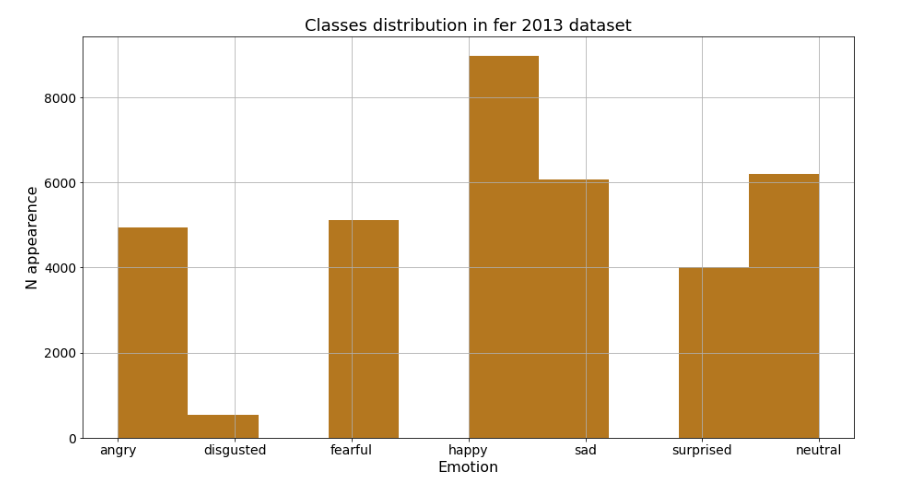

In [109]:
img = cv2.imread('save_files/fer_hist.png')
plt.figure(figsize=(16, 12))
plt.axis('off')
plt.imshow(img)